In [1]:
import flexynesis 
import torch, os
torch.set_num_threads(12)

Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42
Global seed set to 42


In [ ]:
# parameters cell (required to pass arguments to the notebook) (see View -> show right sidebar -> add tag -> parameters)
HPO_ITER = 20 

In [2]:
if not os.path.exists("dataset1"):
    !wget -O ccle_gdsc.tgz "https://bimsbstatic.mdc-berlin.de/akalin/buyar/flexynesis-benchmark-datasets/dataset1.tgz" && tar -xzvf ccle_gdsc.tgz

In [3]:
data_importer = flexynesis.DataImporter(path ='./dataset1/', 
                                       data_types = ['gex', 'cnv'], 
                                        concatenate=False, min_features=100, top_percentile=25)

In [4]:
train_dataset, test_dataset = data_importer.import_data()


[INFO] ================= Importing Data =================
[INFO] Validating data folders...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./dataset1/train/clin.csv...
[INFO] Importing ./dataset1/train/cnv.csv...
[INFO] Importing ./dataset1/train/gex.csv...

[INFO] ----------------- Reading Data ----------------- 
[INFO] Importing ./dataset1/test/clin.csv...
[INFO] Importing ./dataset1/test/cnv.csv...
[INFO] Importing ./dataset1/test/gex.csv...

[INFO] ----------------- Checking for problems with the input data ----------------- 
[INFO] Data structure is valid with no errors or warnings.

[INFO] ----------------- Processing Data (train) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
[INFO] DataFrame gex - Removed 0 samples (0.00%).
[INFO] DataFrame cnv - Removed 0 samples (0.00%

Filtering redundant features: 100%|██████████| 855/855 [00:00<00:00, 888.25it/s] 


[INFO] Implementing feature selection using laplacian score for layer: cnv with  157 features


Filtering redundant features: 100%|██████████| 100/100 [00:00<00:00, 7698.09it/s]



[INFO] ----------------- Processing Data (test) ----------------- 

[INFO] ----------------- Cleaning Up Data ----------------- 
[INFO] Number of NA values:  0
[INFO] DataFrame gex - Removed 0 features.
[INFO] Number of NA values:  0
[INFO] DataFrame cnv - Removed 0 features.
[INFO] DataFrame gex - Removed 0 samples (0.00%).
[INFO] DataFrame cnv - Removed 0 samples (0.00%).

[INFO] ----------------- Harmonizing Data Sets ----------------- 

[INFO] ----------------- Finished Harmonizing ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 

[INFO] ----------------- Normalizing Data ----------------- 
[INFO] Training Data Stats:  {'feature_count in: gex': 855, 'feature_count in: cnv': 100, 'sample_count': 920}
[INFO] Test Data Stats:  {'feature_count in: gex': 855, 'feature_count in: cnv': 100, 'sample_count': 930}
[INFO] Merging Feature Logs...
[INFO] Data import successful.


In [23]:
tuner = flexynesis.HyperparameterTuning(train_dataset, 
                                        model_class = flexynesis.DirectPred, 
                                        target_variables = ["Erlotinib"],
                                        config_name = "DirectPred", 
                                        n_iter=HPO_ITER, plot_losses=True, early_stop_patience=10)

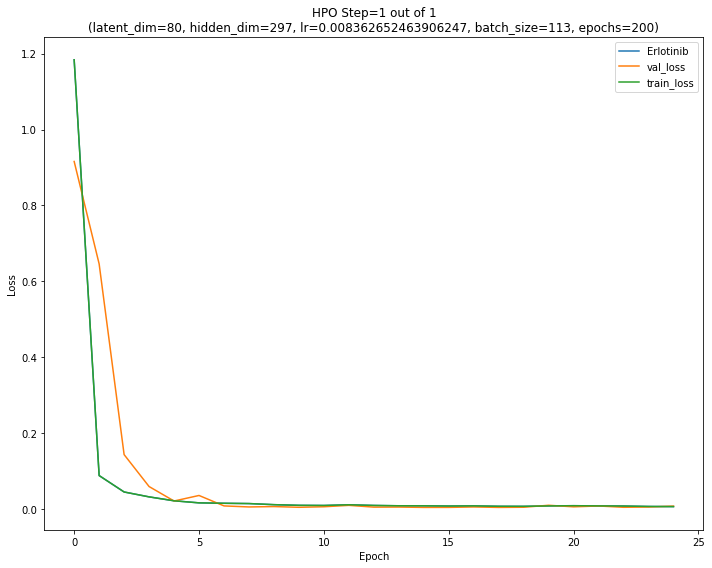

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.004. Signaling Trainer to stop.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Erlotinib         │   0.007956421002745628    │
│         val_loss          │   0.007956421002745628    │
└───────────────────────────┴───────────────────────────┘


Tuning Progress: 100%|██████████| 1/1 [00:12<00:00, 12.40s/it, Iteration=1, Best Loss=0.00796]


{'latent_dim': 80,
 'hidden_dim': 297,
 'lr': 0.008362652463906247,
 'batch_size': 113,
 'epochs': 200}

In [24]:
model, best_params = tuner.perform_tuning()
best_params

In [25]:
y_pred_dict = model.predict(test_dataset)

In [26]:
metrics_df = flexynesis.evaluate_wrapper(y_pred_dict, test_dataset)
metrics_df

,var,variable_type,metric,value
0,Erlotinib,numerical,mse,0.007641
1,Erlotinib,numerical,r2,-0.225954
2,Erlotinib,numerical,pearson_corr,-0.064456


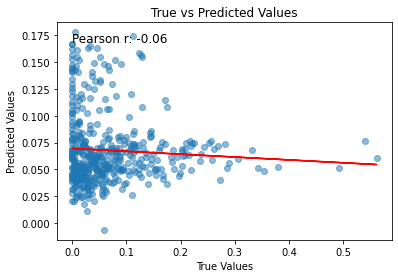

In [27]:
flexynesis.plot_scatter(test_dataset.ann['Erlotinib'].flatten(), y_pred_dict['Erlotinib'].flatten())

In [28]:
for var in model.target_variables:
    model.compute_feature_importance(var, steps = 30)

In [29]:
top_features = flexynesis.get_important_features(model, "Erlotinib", top=10)

In [30]:
top_features

,target_variable,target_class,layer,name,importance
0,Erlotinib,0,cnv,MFAP3,0.001316
1,Erlotinib,0,cnv,ZNF14,0.000921
2,Erlotinib,0,cnv,C1orf174,0.000900
3,Erlotinib,0,cnv,CROCC,0.000894
4,Erlotinib,0,cnv,CDKN2C,0.000872
5,Erlotinib,0,cnv,RNASE2,0.000866
6,Erlotinib,0,cnv,ULK4,0.000862
7,Erlotinib,0,cnv,DEPDC5,0.000788
8,Erlotinib,0,cnv,ZNF208,0.000783
9,Erlotinib,0,cnv,RAPGEF6,0.000780


In [31]:
df = test_dataset.get_feature_subset(top_features)
df

,cnv_MFAP3,cnv_ZNF14,cnv_C1orf174,cnv_CROCC,cnv_CDKN2C,cnv_RNASE2,cnv_ULK4,cnv_DEPDC5,cnv_ZNF208,cnv_RAPGEF6
target_dataset:SNU-719,0.788182,0.020177,0.090568,-0.117252,-0.157650,1.078483,-0.276309,1.375912,-0.403744,1.161549
target_dataset:LOX-IMVI,0.410582,0.816996,-0.384470,-0.392621,-0.362993,0.468617,0.693221,-0.359845,0.833038,0.472707
target_dataset:SNU-324,1.252408,1.243529,1.298958,1.357452,0.942039,1.305891,1.545600,1.570887,1.525202,1.473681
target_dataset:SR,0.692672,1.194314,0.944322,0.991052,0.645055,-0.137115,1.060835,1.856217,0.718039,0.858028
target_dataset:RD,-0.955441,0.364684,-0.141478,-1.095837,0.697663,-0.500968,-0.334885,-0.737908,0.414268,-0.575625
...,...,...,...,...,...,...,...,...,...,...
target_dataset:SET-2,-3.132193,-0.422761,-0.377903,-0.385794,-0.357902,-0.565055,-0.385381,-0.305157,-0.314782,-2.812210
target_dataset:ACC-MESO-1,1.441208,-1.453938,-1.371760,-0.843225,0.088422,-1.925368,-0.338925,-0.985194,-1.269491,0.571728
target_dataset:TE-5,-0.931008,-0.732114,-0.550842,-0.565580,-0.581913,0.416933,-0.425778,-3.053836,-0.755250,-0.709088
target_dataset:HCC38,-0.360166,-0.059505,-0.012321,0.171772,-0.086374,-0.252887,0.111503,0.137104,0.021536,0.558812


In [33]:
df.columns[0]

'cnv_MFAP3'

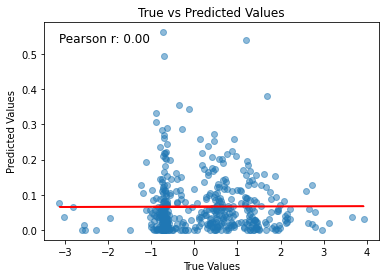

In [34]:
# plot top feature correlation with Erlotinib response
f = df.columns[0]
flexynesis.plot_scatter(df[f], test_dataset.ann['Erlotinib'])

In [35]:
response_category = flexynesis.split_by_median(test_dataset.ann['Erlotinib'])

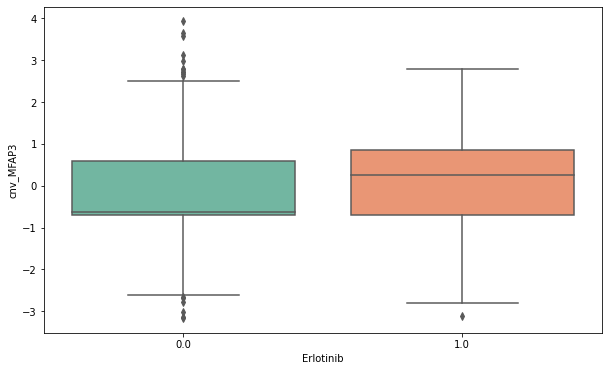

In [36]:
flexynesis.plot_boxplot(response_category, df[f], 'Erlotinib', f)